In [156]:
# 1. Dataset
import torchio as tio
from torch.utils.data import DataLoader

from data.load import load_data, preprocess

data_path='D:\data\BraTS2020\MICCAI_BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData'
base_transform = tio.Compose(
    [
        tio.ToCanonical(),
        tio.CropOrPad(target_shape=(192, 192, 144)),
        tio.Resample(target=(1.5, 1.5, 1.5)),
        tio.ZNormalization()
    ]
)

# load
x, y = load_data(data_path=data_path)
# preprocess
dataset = tio.SubjectsDataset(list(x), transform=base_transform)
data_loader = DataLoader (dataset, num_workers=8)
x = preprocess(data_loader)
print(f'Finish Pre-processing Dataset from {data_path}')

Preprocessing Dataset:
---10%---20%---30%---40%---50%---60%---70%---80%---90%---100% Finished.
Finish Pre-processing Dataset from D:\data\BraTS2020\MICCAI_BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData


In [157]:
# 2. Model
import torch
from models.protos import ProtoNets

# build
kwargs = {
    'in_size': (4, 128, 128, 96),
    'out_size': 2,
    'backbone': 'resnet152_quad',
    'n_res_block': 1,
    'prototype_shape': (30, 128, 1, 1, 1),
    'f_dist': 'cos',
    'p_mode': 3,
    'n_scales': 2,
    'scale_mode': 'c'
}
net = ProtoNets(**kwargs)
# load
model_path = './results/models/maprotonet_eefb07f7_cv0.pt'  # please put your own model if necessary
net.load_state_dict(torch.load(model_path))
print(f'Finish Loading Model from {model_path}')

Finish Loading Model from ./results/models/maprotonet_eefb07f7_cv0.pt


In [158]:
# 3. Diagnosis & Attribution
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm

from data.load import load_subjs_batch
from utils.interpret import attribute

def diag_and_attr(net, data_loader, device):
    net = net.to(device).eval()
    f_x, attrs, ys = [], [], []
    if isinstance(net, ProtoNets):
        method = 'ProtoNets'
    else:
        method = 'GradCAM'
    with torch.no_grad():
        for b, subjs_batch in enumerate(tqdm(data_loader)):
            data, target, _ = load_subjs_batch(subjs_batch)
            data = data.to(device, non_blocking=True)
            target = target.argmax(1).to(device, non_blocking=True)
            # forward
            f_x.append(F.softmax(net(data), dim=1).cpu().numpy())
            ys.extend(list(target.cpu().numpy()))
            # attribute            
            attr = attribute(net, data, target, method)
            attrs.append(attr.cpu().numpy()[:, 0])
    return np.vstack(f_x), np.array(ys), np.vstack(attrs)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# reload dataset
n_sample = 8  # only use 8 samples as an example here
dataset = tio.SubjectsDataset(list(x[:n_sample]))
data_loader = DataLoader(dataset, batch_size=8, num_workers=8, pin_memory=True, shuffle=False)
# forward
f_x, ys, attrs = diag_and_attr(net, data_loader, device)
print('Forwarding Complete')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.07s/it]

Forwarding Complete


In [159]:
# 4. Visualize
import os
import cv2

saved = True  # whether to save the resulting figures
save_path = './visualize/'
modalities = ['t1ce', 'flair']  # only use t1ce and flair as an example here

if saved:    
    if not os.path.exists(save_path):
        os.makedirs(save_path)

modality_ids = {'t1': 0, 't2': 1, 't1ce': 2, 'flair': 3}

gts = {}
combines = {}
for m in modalities:
    gts[m] = []
    combines[m] = []
reserved_id = []

for i, (raw_x, attr) in enumerate(zip(list(dataset), attrs)):
    # 4.1. load and slice
    # get raw MRI 'raw_x', attribution map 'attr' and the segmentation map (ground truth) 'seg'
    seg = np.array(raw_x['seg'])[0]
    raw_x = np.concatenate([raw_x['t1'], raw_x['t2'], raw_x['t1ce'], raw_x['flair']], axis=0)
    # only use the middle slice of depth (the third dimension in (H, W, D)) for visualization
    axial_median = attr.shape[-1] // 2  
    x_median, attr_median, seg_median = raw_x[..., axial_median], attr[..., axial_median], seg[..., axial_median]
    # 4.2. calculate bounding box according to the segmentation map
    seg_median = np.array(seg_median >= 1, dtype=int)
    seg_median = np.uint8(255 * seg_median)
    seg_rot = cv2.rotate(seg_median, cv2.ROTATE_90_COUNTERCLOCKWISE)
    xx = np.sum(seg_rot, axis=0)
    yy = np.sum(seg_rot, axis=1)
    xx = np.nonzero(xx)[0]
    yy = np.nonzero(yy)[0]
    if len(xx) == 0:  # if the ground truth has a very small bounding box, then drop it
        continue
    x_start, x_end = xx[0], xx[-1]
    y_start, y_end = yy[0], yy[-1]
    # 4.3. reload segmentation map
    seg_median = cv2.applyColorMap(seg_median, cv2.COLORMAP_JET)
    cv2.imwrite('temp_seg.png', seg_median)  # temporary files
    seg_median = cv2.imread('temp_seg.png')
    # 4.4. calculate heatmap from attribution map
    attr_median = (attr_median - np.min(attr_median)) / (np.max(attr_median) - np.min(attr_median))
    heatmap = cv2.applyColorMap(np.uint8(255 * attr_median), cv2.COLORMAP_JET)
    # 4.5. visualize
    for m in modalities:
        # raw image
        m_id = modality_ids[m]
        x_i = x_median[m_id]
        x_i = (x_i - np.min(x_i)) / (np.max(x_i) - np.min(x_i))
        x_i = np.uint8(255 * x_i)
        cv2.imwrite('temp_raw.png', x_i)  # temporary files
        x_i = cv2.imread('temp_raw.png')   
    
        # raw + attribution map + bounding box 
        combine = cv2.rotate(x_i, cv2.ROTATE_90_COUNTERCLOCKWISE)
        combine = cv2.addWeighted(heatmap, 0.4, x_i, 0.6, 0)
        combine = cv2.rotate(combine, cv2.ROTATE_90_COUNTERCLOCKWISE)
        combine = cv2.rectangle(combine, (x_start, y_start), (x_end, y_end), (153, 201, 245), 1)
        
        # raw + attribution map + crop
        crop = combine[y_start+1:y_end, x_start+1:x_end].copy()
        
        # raw + segmentation map (ground truth) + bounding box
        gt = cv2.addWeighted(seg_median, 0.4, x_i, 0.6, 0)
        gt = cv2.rotate(gt, cv2.ROTATE_90_COUNTERCLOCKWISE)
        gt = cv2.rectangle(gt, (x_start, y_start), (x_end, y_end), (153, 201, 245), 1)

        # raw + segmentation map (ground truth) + crop
        crop_gt = gt[y_start+1:y_end, x_start+1:x_end].copy()
        
        # save
        if saved:
            cv2.imwrite(save_path + f'{i}_{m}_raw.png', x_i)
            cv2.imwrite(save_path + f'{i}_{m}_combine.png', combine)
            cv2.imwrite(save_path + f'{i}_{m}_crop_combine.png', crop)
            cv2.imwrite(save_path + f'{i}_{m}_gt.png', gt)
            cv2.imwrite(save_path + f'{i}_{m}_crop_gt.png', crop_gt)
        
        combines[m].append(combine)
        gts[m].append(gt)
    
    reserved_id.append(i)
    
os.remove('temp_seg.png')
os.remove('temp_raw.png')

f_x = f_x[reserved_id]
ys = ys[reserved_id]

print('Finish Processing for Visualization')

Finish Processing for Visualization


----------------------------------------------------------------------------------------------------
The diagnosis logits are:  [[0.16635457 0.8336454 ]
 [0.29144207 0.7085579 ]
 [0.2840224  0.7159776 ]
 [0.22096205 0.779038  ]
 [0.40069348 0.59930646]
 [0.20965548 0.79034454]]
The classification labels are:  [1 1 1 1 1 1]
----------------------------------------------------------------------------------------------------
The diagnosis results are:  ['HGG', 'HGG', 'HGG', 'HGG', 'HGG', 'HGG']
The ground truth results are:  ['HGG', 'HGG', 'HGG', 'HGG', 'HGG', 'HGG']
----------------------------------------------------------------------------------------------------


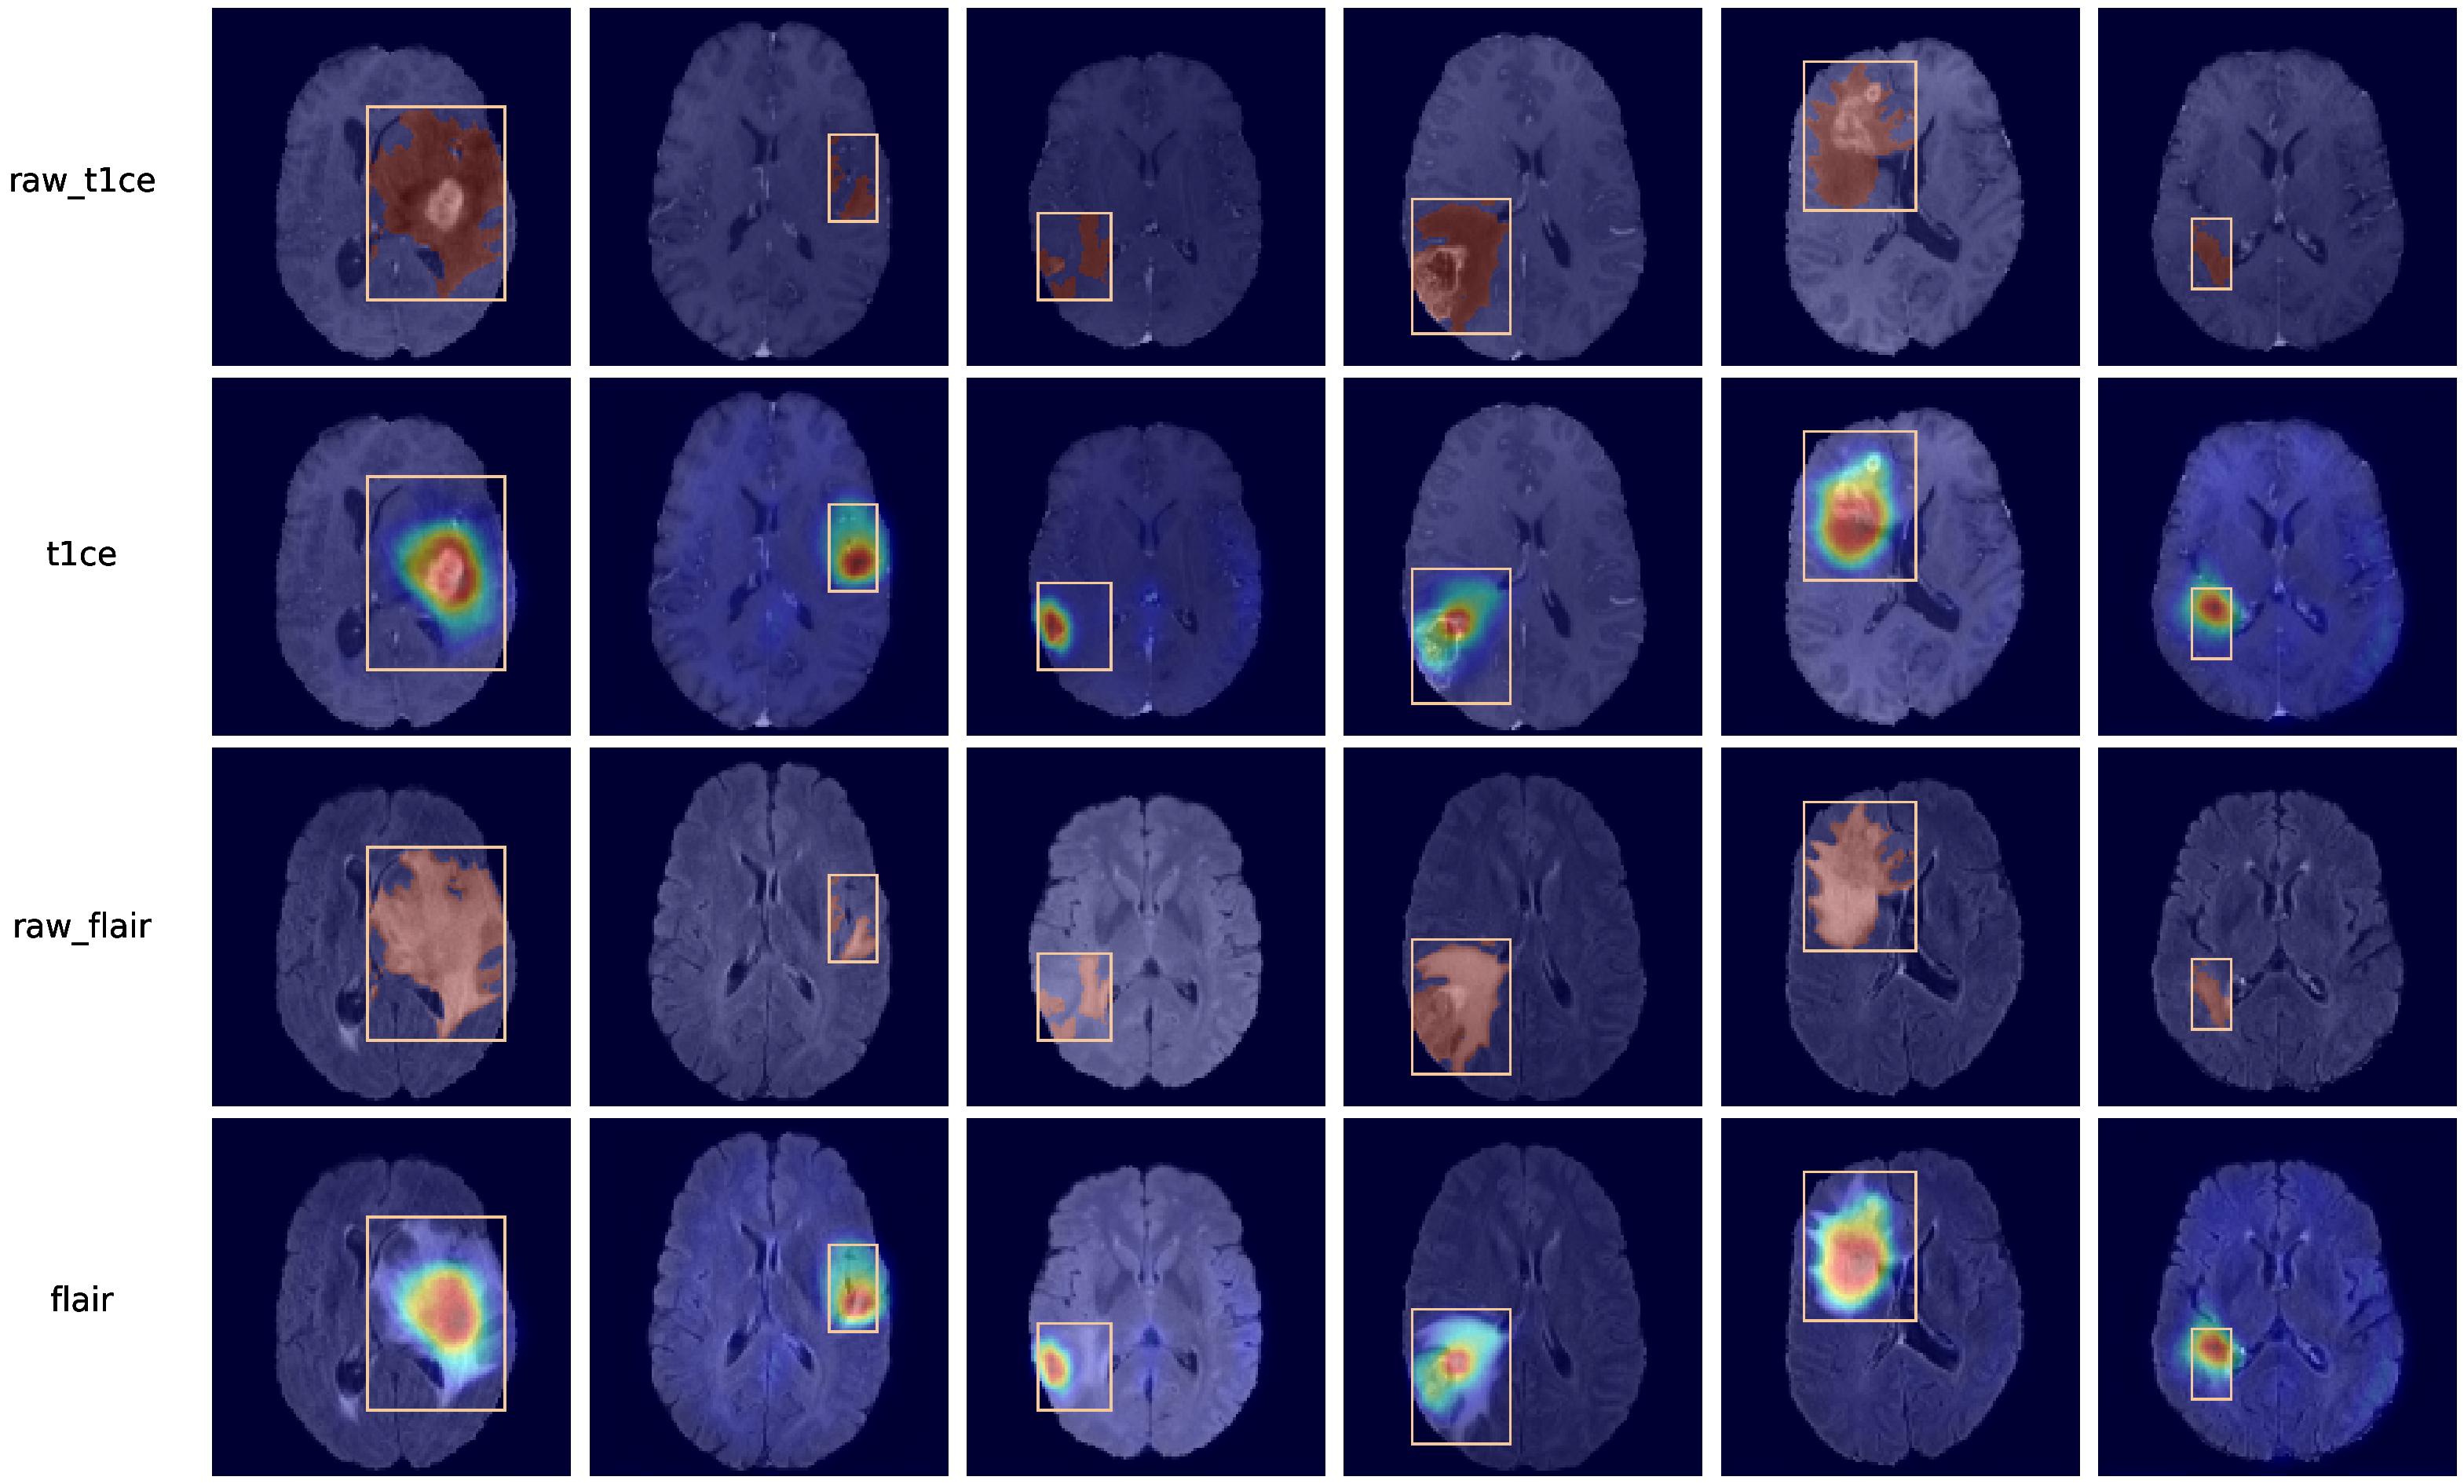

In [166]:
# 5. Show
import matplotlib.pyplot as plt

n_samples = 6  # only use 6 samples to display here
img_size = 4
gap = 1

assert len(modalities) > 0 and len(gts[modalities[0]]) > 0, 'The list is empty. You do not have samples to plot.'

def cv2matplot(img):
    b, g, r = cv2.split(img)
    return cv2.merge((r, g, b))

n_columns = min(n_samples, len(gts[modalities[0]]))  # only plot 4 or less samples as an example
n_rows = len(modalities) * 2
figsize = (img_size * n_columns + gap * (n_columns - 1), img_size * n_rows + gap * (n_rows - 1))
text_gap = 1 / n_rows

fig, axs = plt.subplots(n_rows, n_columns, figsize=figsize)

for c in range(n_columns):  # n_sample
    for r in range(n_rows):  # n_modalities * 2, for raw and attribution results
        modality = modalities[r // 2]
        if r % 2  == 0:
            axs[r, c].imshow(cv2matplot(gts[modality][c]))
            fig.text(-0.05, 1 - text_gap * (r + 0.5), 'raw_' + modality, ha='center', va='center', fontsize=5 * n_columns)
            axs[r, c].axis('off')
        else:
            axs[r, c].imshow(cv2matplot(combines[modality][c]))
            fig.text(-0.05, 1 - text_gap * (r + 0.5), modality, ha='center', va='center', fontsize=5 * n_columns)
            axs[r, c].axis('off')

# label
label_dict = {0: 'LGG', 1: 'HGG'}
print('-' * 100)
print('The diagnosis logits are: ', f_x[:n_columns])
print('The classification labels are: ', ys[:n_columns])
print('-' * 100)
print('The diagnosis results are: ', [label_dict[item] for item in np.argmax(f_x, axis=-1)[:n_columns]])
print('The ground truth results are: ', [label_dict[item] for item in ys[:n_columns]])
print('-' * 100)

plt.tight_layout()
plt.show()